# Risk Management Strategies

**This script performs a Monte Carlo simulation to evaluate the expected return and risk (volatility) of a portfolio made up of selected stocks.**

This project compared two portfolio construction methodologies—Equal Weight (EW) and Hierarchical Risk Parity (HRP)—to assess their performance, risk characteristics, and diversification benefits.

#### Key Concepts Explored

1. Performance Comparison: Which strategy delivers better risk-adjusted returns (Sharpe ratio)?

2. Risk Allocation: How does each strategy distribute risk across assets?

3. Diversification: Which approach provides better diversification benefits?

4. Correlation Impact: How does asset correlation affect the strategies differently?

The code provides a comprehensive framework to evaluate these two common portfolio construction approaches, particularly focusing on their risk management characteristics.

In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from pypfopt import HRPOpt, risk_models, expected_returns
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.plotting import plot_weights

## Data Loading and Preparation

In [2]:
# Path to your zip file
zip_path = 'Stock Portfolio Optimization Dataset.zip'

In [3]:
# Create a dictionary to store all DataFrames
dataframes = {}

# List of expected files
expected_files = [
    'all_ten.csv',
    'original_risks_returns.csv',
    'stock_data2.csv',
    'stock_data3.csv',
    'stock_data_strong.csv',
    'stock_data_weak.csv',
    'strong_risks_returns.csv',
    'weak_risks_returns.csv'
]

# Load all files from the zip archive
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Check which expected files are present
    available_files = [f for f in expected_files if f in zip_ref.namelist()]
    
    # Load each available file into a DataFrame
    for file in available_files:
        with zip_ref.open(file) as f:
            # Remove .csv extension for cleaner dictionary keys
            df_name = file.replace('.csv', '')
            dataframes[df_name] = pd.read_csv(f)
            
    # Print loaded files
    print("Successfully loaded the following files:")
    for file in available_files:
        print(f"- {file}")
    
    # Print any missing expected files
    missing_files = set(expected_files) - set(available_files)
    if missing_files:
        print("\nThe following expected files were not found in the zip:")
        for file in missing_files:
            print(f"- {file}")

Successfully loaded the following files:
- all_ten.csv
- original_risks_returns.csv
- stock_data2.csv
- stock_data3.csv
- stock_data_strong.csv
- stock_data_weak.csv
- strong_risks_returns.csv
- weak_risks_returns.csv


## Clean the Data

In [4]:
# Convert date columns to datetime and set as index
for name in ['stock_data2', 'stock_data3', 'stock_data_strong', 'stock_data_weak']:
    if name in dataframes:
        dataframes[name]['Date'] = pd.to_datetime(dataframes[name]['Date'])
        dataframes[name].set_index('Date', inplace=True)

def normalize_prices(df):
    """Normalize all numeric columns to start at 100 for comparison"""
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].apply(lambda x: (x / x.iloc[0]) * 100)
    return df

# Apply to stock data files
for name in ['stock_data2', 'stock_data3', 'stock_data_strong', 'stock_data_weak']:
    if name in dataframes:
        dataframes[name] = normalize_prices(dataframes[name])

def calculate_returns(df):
    """Calculate daily returns from price data"""
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    return df[numeric_cols].pct_change().dropna()

# Create returns datasets
returns_data = {}
for name in ['stock_data2', 'stock_data3', 'stock_data_strong', 'stock_data_weak']:
    if name in dataframes:
        returns_name = name + '_returns'
        returns_data[returns_name] = calculate_returns(dataframes[name])

for name in ['all_ten', 'original_risks_returns', 'strong_risks_returns', 'weak_risks_returns']:
    if name in dataframes:
        # Ensure no negative risk values
        dataframes[name]['Risks'] = dataframes[name]['Risks'].abs()
        # Ensure returns are reasonable
        dataframes[name]['Returns'] = dataframes[name]['Returns'].clip(lower=-1, upper=1)  # Bound between -100% and +100%

## Define Function for Portfolio Strategy Comparison Code

This code compares two portfolio construction strategies (Equal Weight and Risk Parity) and analyzes their diversification benefits.

**This funcion calculates key portfolio performance metrics.**

In [5]:
def calculate_portfolio_metrics(weights, returns_df, risk_free_rate=0.02):
    """
    Calculate portfolio performance metrics given weights
    
    Parameters:
    weights: Dictionary of {asset: weight}
    returns_df: DataFrame of asset returns
    risk_free_rate: Annual risk-free rate
    
    Returns:
    Dictionary of portfolio metrics
    """
    # Convert weights to numpy array in correct order
    ordered_weights = np.array([weights[asset] for asset in returns_df.columns])
    
    # Calculate metrics
    annual_returns = returns_df.mean() * 252
    cov_matrix = returns_df.cov() * 252
    
    portfolio_return = np.sum(annual_returns * ordered_weights)
    portfolio_vol = np.sqrt(np.dot(ordered_weights.T, np.dot(cov_matrix, ordered_weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_vol
    
    return {
        'return': portfolio_return,
        'volatility': portfolio_vol,
        'sharpe': sharpe,
        'weights': weights
    }


**Creates an equal weight portfolio**

In [6]:
def equal_weight_portfolio(returns_df):
    """
    Create equal weight portfolio
    
    Parameters:
    returns_df: DataFrame of asset returns
    
    Returns:
    Dictionary of equal weight portfolio metrics
    """
    n = len(returns_df.columns)
    weights = {asset: 1/n for asset in returns_df.columns}
    return calculate_portfolio_metrics(weights, returns_df)

**Creates a risk parity portfolio using Hierarchical Risk Parity (HRP)**

In [7]:
def risk_parity_portfolio(returns_df):
    """
    Create risk parity portfolio using Hierarchical Risk Parity
    
    Parameters:
    returns_df: DataFrame of asset returns
    
    Returns:
    Dictionary of risk parity portfolio metrics
    """
    hrp = HRPOpt(returns_df)
    hrp_weights = hrp.optimize()
    return calculate_portfolio_metrics(hrp_weights, returns_df)

**Compares the two strategies side-by-side**

In [8]:
def compare_portfolio_strategies(returns_df, plot=True):
    """
    Compare equal weight vs. risk parity strategies
    
    Parameters:
    returns_df: DataFrame of asset returns
    plot: Whether to generate visualizations
    
    Returns:
    Tuple of (equal_weight_metrics, risk_parity_metrics)
    """
    # Calculate both strategies
    equal_weight = equal_weight_portfolio(returns_df)
    risk_parity = risk_parity_portfolio(returns_df)
    
    # Print comparison
    print("\n" + "="*80)
    print(" PORTFOLIO STRATEGY COMPARISON ".center(80, "="))
    print("="*80)
    
    print("\nEqual Weight Portfolio:")
    print(f"{'Return:':<15}{equal_weight['return']:.2%}")
    print(f"{'Volatility:':<15}{equal_weight['volatility']:.2%}")
    print(f"{'Sharpe Ratio:':<15}{equal_weight['sharpe']:.2f}")
    
    print("\nRisk Parity Portfolio:")
    print(f"{'Return:':<15}{risk_parity['return']:.2%}")
    print(f"{'Volatility:':<15}{risk_parity['volatility']:.2%}")
    print(f"{'Sharpe Ratio:':<15}{risk_parity['sharpe']:.2f}")
    
    if plot:
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot weights comparison
        pd.Series(equal_weight['weights']).plot.bar(
            ax=ax1, color='skyblue', edgecolor='black', title='Equal Weight Allocation'
        )
        ax1.yaxis.set_major_formatter(PercentFormatter(1))
        ax1.set_ylabel('Weight')
        
        pd.Series(risk_parity['weights']).plot.bar(
            ax=ax2, color='lightgreen', edgecolor='black', title='Risk Parity Allocation'
        )
        ax2.yaxis.set_major_formatter(PercentFormatter(1))
        ax2.set_ylabel('Weight')
        
        plt.tight_layout()
        plt.show()
        
        # Plot risk contribution
        cov_matrix = returns_df.cov() * 252
        plot_risk_contribution(equal_weight['weights'], cov_matrix, "Equal Weight Risk Contribution")
        plot_risk_contribution(risk_parity['weights'], cov_matrix, "Risk Parity Risk Contribution")
    
    return equal_weight, risk_parity


**Visualizes how much each asset contributes to total portfolio risk**

In [9]:
def plot_risk_contribution(weights, cov_matrix, title):
    """
    Plot risk contribution of each asset
    
    Parameters:
    weights: Dictionary of asset weights
    cov_matrix: Annualized covariance matrix
    title: Plot title
    """
    # Convert weights to numpy array in correct order
    w = np.array([weights[asset] for asset in cov_matrix.columns])
    
    # Calculate risk contribution
    portfolio_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    marginal_risk = np.dot(cov_matrix, w) / portfolio_vol
    risk_contribution = w * marginal_risk
    percent_risk_contribution = risk_contribution / portfolio_vol
    
    # Create plot
    plt.figure(figsize=(10, 6))
    pd.Series(percent_risk_contribution, index=cov_matrix.columns).plot.bar(
        color='salmon', edgecolor='black'
    )
    plt.title(title)
    plt.ylabel('Percentage of Total Risk')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.axhline(1/len(weights), color='red', linestyle='--', 
                label='Equal Risk Contribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Quantifies diversification benefits**

In [10]:
def analyze_diversification(returns_df, strategies):
    """
    Analyze diversification benefits of each strategy
    
    Parameters:
    returns_df: DataFrame of asset returns
    strategies: Dictionary of strategy metrics
    """
    print("\n" + "="*80)
    print(" DIVERSIFICATION ANALYSIS ".center(80, "="))
    print("="*80)
    
    # Calculate correlation matrix
    corr_matrix = returns_df.corr()
    avg_correlation = (corr_matrix.values.sum() - len(corr_matrix)) / (len(corr_matrix)*(len(corr_matrix)-1))
    print(f"\nAverage Asset Correlation: {avg_correlation:.2f}")
    
    for name, metrics in strategies.items():
        weights = np.array([metrics['weights'][asset] for asset in returns_df.columns])
        
        # Diversification ratio (DR)
        weighted_vol = np.sqrt(np.diag(returns_df.cov() * 252))
        dr = np.sum(weights * weighted_vol) / metrics['volatility']
        
        # Effective number of bets (ENB)
        risk_contributions = weights * np.dot(returns_df.cov() * 252, weights) / metrics['volatility']**2
        enb = 1 / np.sum(risk_contributions**2)
        
        print(f"\n{name} Strategy:")
        print(f"Diversification Ratio: {dr:.2f} (Higher = better diversified)")
        print(f"Effective Number of Bets: {enb:.2f}")



======================== PORTFOLIO STRATEGY COMPARISON =========================

Equal Weight Portfolio:
Return:        256.71%
Volatility:    137.80%
Sharpe Ratio:  1.85

Risk Parity Portfolio:
Return:        214.67%
Volatility:    108.68%
Sharpe Ratio:  1.96


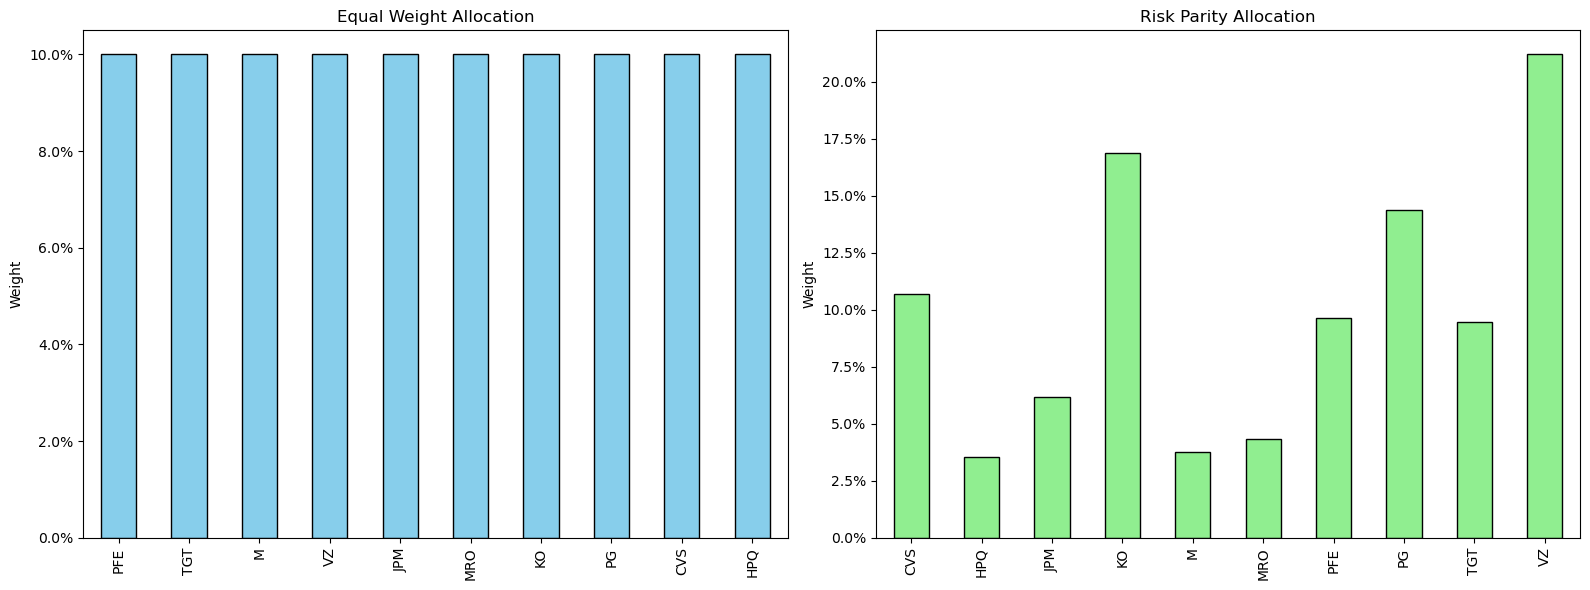

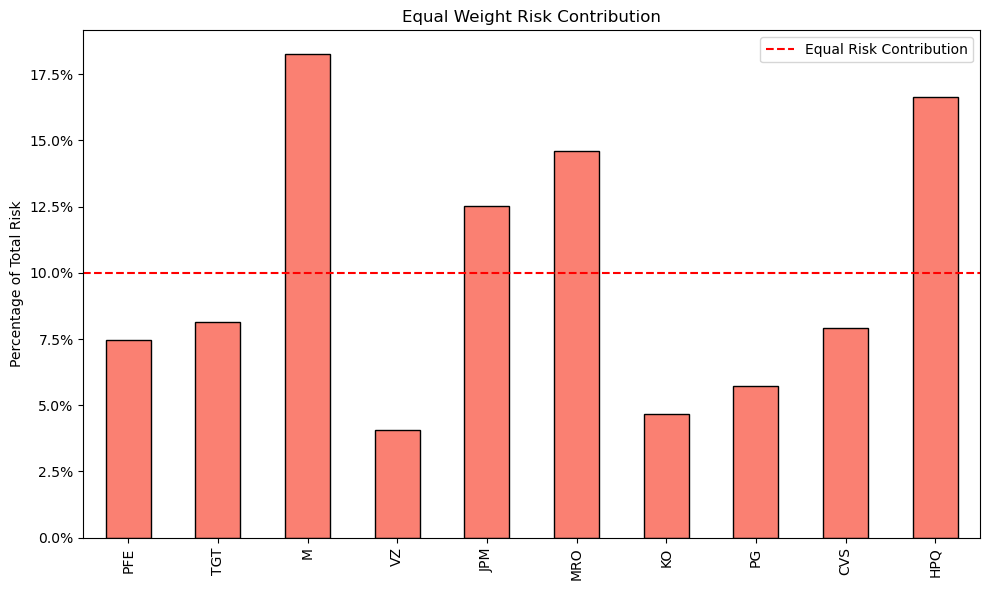

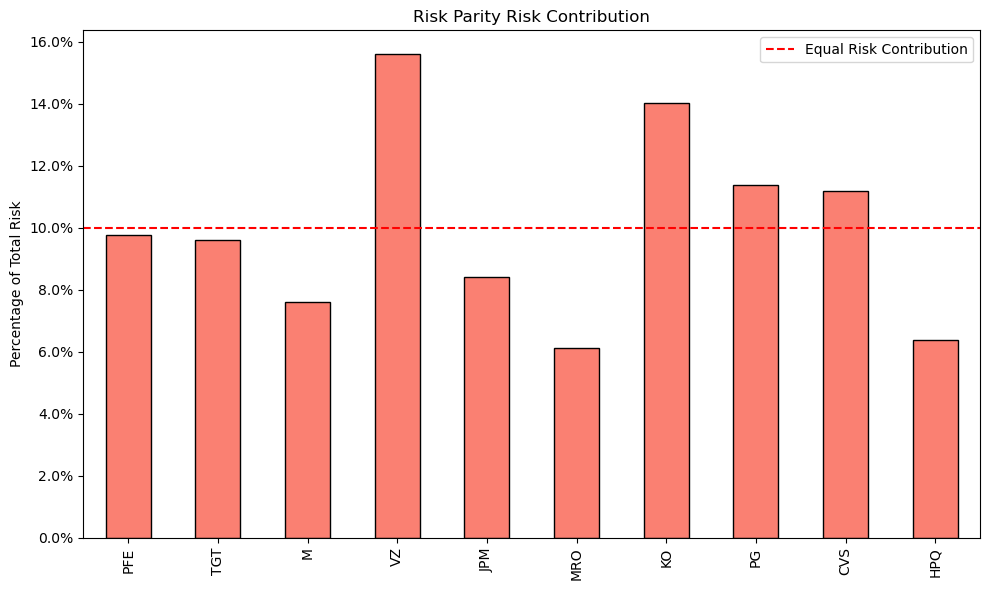


=========================== DIVERSIFICATION ANALYSIS ===========================

Average Asset Correlation: 0.32

Equal Weight Strategy:
Diversification Ratio: 1.56 (Higher = better diversified)
Effective Number of Bets: 8.09

Risk Parity Strategy:
Diversification Ratio: 1.64 (Higher = better diversified)
Effective Number of Bets: 9.20


In [11]:
# Example usage
if __name__ == "__main__":
    # Load your returns data
    returns = returns_data['stock_data3_returns']  # Using your existing data
    
    # Compare strategies
    equal_weight, risk_parity = compare_portfolio_strategies(returns)
    
    # Analyze diversification benefits
    strategies = {
        'Equal Weight': equal_weight,
        'Risk Parity': risk_parity
    }
    analyze_diversification(returns, strategies)

### Performance Comparison

**Equal Weight Portfolio:**
- Return: 256.71% (annualized)
- Volatility: 137.80% (annualized standard deviation)
- Sharpe Ratio: 1.85 (risk-adjusted return)

**Risk Parity Portfolio:**
- Return: 214.67%
- Volatility: 108.68%
- Sharpe Ratio: 1.96

#### Key Observations:
- The equal weight portfolio has higher raw returns but also significantly higher volatility.
- The risk parity portfolio sacrificed some return (214.67% vs 256.71%) but achieved much lower volatility (108.68% vs 137.80%).
- Despite lower returns, risk parity has a slightly better Sharpe ratio (1.96 vs 1.85), meaning it delivered better risk-adjusted returns.

### Diversification Analysis

Market Context:
- Average Asset Correlation: 0.32
- This suggests moderate correlation among your assets (0 = no correlation, 1 = perfect correlation)

Equal Weight Strategy:
- Diversification Ratio: 1.56
- Effective Number of Bets: 8.09

Risk Parity Strategy:
- Diversification Ratio: 1.64
- Effective Number of Bets: 9.20

#### Key Observations:

Both strategies show good diversification (DR > 1, ENB close to the actual number of assets)

Risk parity achieves better diversification metrics:

- Higher diversification ratio (1.64 vs 1.56)
- More "independent bets" (9.20 vs 8.09)

The 0.32 average correlation explains why both strategies could achieve decent diversification - assets weren't moving in perfect lockstep.

### Practical Implications

1. Risk-Return Tradeoff: The risk parity approach successfully reduced volatility more than it reduced returns, leading to better risk-adjusted performance.

2. Diversification Effectiveness: The higher ENB for risk parity suggests it's doing a better job of spreading risk across truly independent sources rather than just holding many assets.

3. Strategy Selection Depends On:
- If you can tolerate higher volatility for higher returns → Equal weight
- If you prefer more stable, risk-balanced returns → Risk parity
- The Sharpe ratio suggests risk parity is mathematically superior in this case

4. Portfolio Construction Insight: The moderate correlation (0.32) means neither strategy is dealing with either perfectly diversifiable assets (0) or completely redundant holdings (1), allowing both approaches to work reasonably well.

## Conclusion

While both strategies have merits, Risk Parity (HRP) emerges as the more robust choice for long-term investors prioritizing risk management and stable growth. However, if maximizing returns is the primary goal and volatility is acceptable, Equal Weighting remains a viable alternative. Future work could explore hybrid approaches or incorporate additional factors like macroeconomic regimes to further optimize allocations.

1. Performance & Risk-Adjusted Returns
- The Equal Weight portfolio delivered higher absolute returns (256.71% vs. 214.67%) but at the cost of significantly higher volatility (137.80% vs. 108.68%).
- The Risk Parity approach achieved a superior Sharpe ratio (1.96 vs. 1.85), indicating better risk-adjusted returns despite slightly lower raw performance.

2. Risk Management & Diversification
Risk Parity demonstrated stronger diversification benefits:
- Higher Diversification Ratio (1.64 vs. 1.56), meaning it better balances risk across assets.
- Higher Effective Number of Bets (9.20 vs. 8.09), suggesting a more efficient distribution of risk sources.
- The moderate average asset correlation (0.32) helped both strategies achieve diversification, but HRP was more effective at mitigating concentrated risk exposures.

3. Practical Implications
- For investors seeking higher returns and willing to tolerate volatility, an Equal Weight approach may be suitable.
- For risk-conscious investors, Risk Parity provides a more balanced portfolio with smoother performance and better downside protection.
- The HRP strategy’s hierarchical clustering makes it particularly useful in markets with varying asset correlations, as it dynamically adjusts to risk dependencies.